In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [16]:
fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

wsrc = '../hpcc/clean/'
dst =  '../hpcc/rotated/'

idname = 'GB'
rownum = 5
treenum = 3
nutnum = 7

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')

mxval = 2**(8*img.itemsize)

nutvol = np.sum(img > 0) * (resol ** 3)

bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
nutvoxarea = np.sum(border)

GB_R5_T3
../hpcc/rotated/GB_R5_T3/
GB_R5_T3_007


In [17]:
filename = dst + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol
rcoords = rotxyz @ datapoints

# Verify rotation

Tip coords:	 [20.9 -0.   0. ]


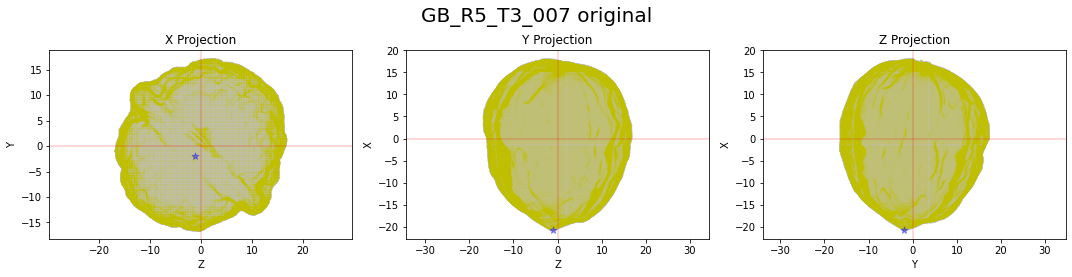

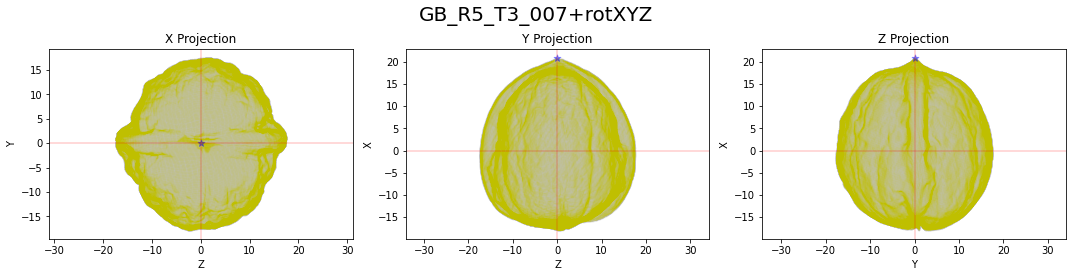

In [18]:
print('Tip coords:\t', np.round(rtipvox, 2))

fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(rcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

# Manuscript


In [19]:
tsrc = '../hpcc/watershed/'
tissuefiles = tsrc + bname + '/' + fname + '_'
meat = tf.imread(tissuefiles + 'meat.tif')

bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
border[border > 0] = 1
datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

In [20]:
kk = 0
phalfnx = rcoords[:, rcoords[0] >  kk]
nhalfnx = rcoords[:, rcoords[0] < -kk]

phalfny = rcoords[:, rcoords[1] >  kk]
nhalfny = rcoords[:, rcoords[1] < -kk]

phalfnz = rcoords[:, rcoords[2] >  kk]
nhalfnz = rcoords[:, rcoords[2] < -kk]

In [77]:
phalfkx = mcoords[:, mcoords[0] >  kk]
nhalfkx = mcoords[:, mcoords[0] < -kk]

phalfky = mcoords[:, mcoords[1] >  kk]
nhalfky = mcoords[:, mcoords[1] < -kk]

phalfkz = mcoords[:, mcoords[2] >  kk]
nhalfkz = mcoords[:, mcoords[2] < -kk]

../../writing/walnut_figs/GB_R5_T3_007_nut.jpg


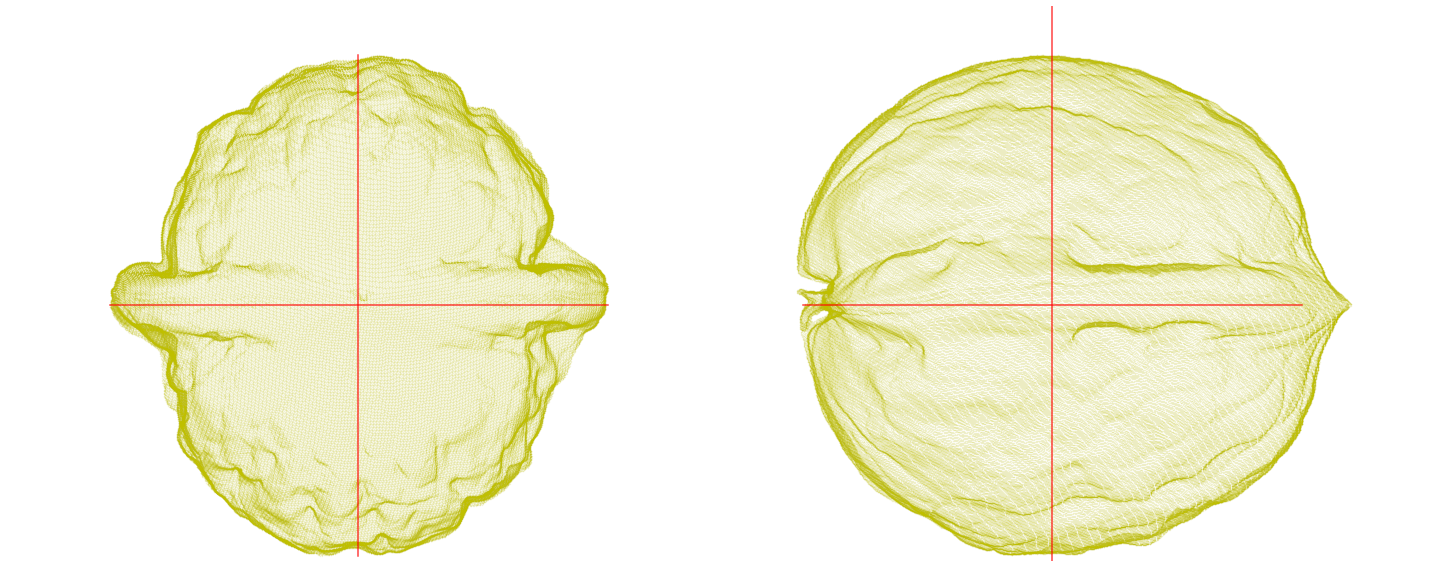

In [84]:
dst = '../../writing/walnut_figs/'
fs = 35
fig, ax = plt.subplots(1,2,figsize=(20,8), sharex=False, sharey=True, facecolor='w')
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(phalfnx[2], phalfnx[1], s=.5, color='y', alpha=.2, marker='.')
ax[i].plot([np.min(phalfnx[2]), np.max(phalfnx[2])],[0,0],color='r',alpha=0.75)
ax[i].plot([0,0],[np.min(phalfnx[1]), np.max(phalfnx[1])],color='r',alpha=0.75)
i+=1
ax[i].scatter(phalfnz[0], phalfnz[1], s=.5, color='y', alpha=.2, marker='.');
ax[i].plot([np.min(phalfnz[1]), np.max(phalfnz[1])],[0,0],color='r',alpha=0.75)
ax[i].plot([0,0],[np.min(phalfnz[0]), np.max(phalfnz[0])],color='r',alpha=0.75)

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].axis('off')
    ax[i].margins(0)
    
    ax[i].tick_params(labelsize=fs)
fig.tight_layout();

filename = dst + fname + '_nut.jpg'
print(filename)

40.36582233261913
../../writing/walnut_figs/GB_R5_T3_007_walnut


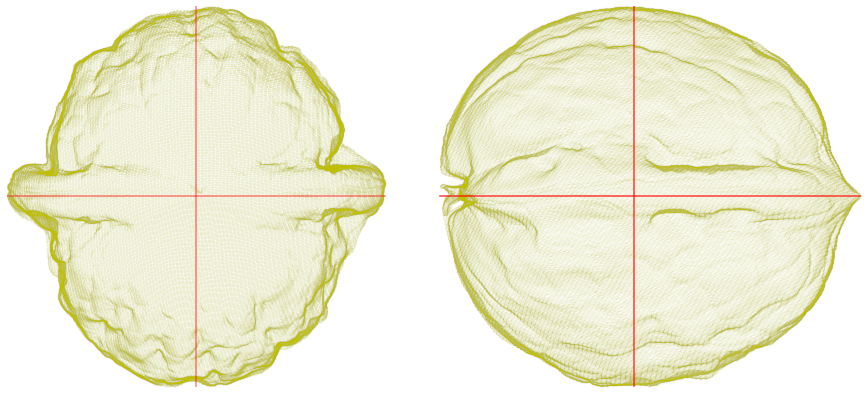

In [95]:
sep = np.max(phalfnx[2]) - np.min(phalfnz[0]) + 5
print(sep)

ncombinedx = np.hstack((phalfnx[2], phalfnz[0]+sep))
ncombinedy = np.hstack((phalfnx[1], phalfnz[1]))

fig, ax = plt.subplots(1,1,figsize=(16,7), facecolor='w')
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].scatter(ncombinedx, ncombinedy, s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([np.min(phalfnx[2]), np.max(phalfnx[2])],[0,0],color='r',alpha=0.5)
ax[i].plot([0,0],[np.min(phalfnx[1]), np.max(phalfnx[1])],color='r',alpha=0.5)

ax[i].plot([np.min(phalfnz[0])+sep, np.max(phalfnz[0])+sep],[0,0],color='r',alpha=0.75)
ax[i].plot([sep,sep],[np.min(phalfnz[1]), np.max(phalfnz[1])],color='r',alpha=0.75)

ax[i].set_aspect('equal');
ax[i].axis('off');
ax[i].margins(0)

filename = dst + fname + '_walnut'
print(filename)
#plt.savefig(filename + '.jpg', format='jpg', bbox_inches='tight', dpi=250, pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight', dpi=250);

32.62902035159814
../../writing/walnut_figs/GB_R5_T3_007_kernel


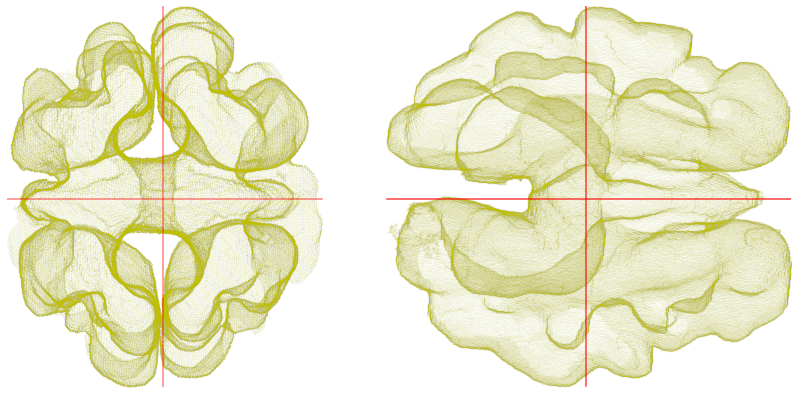

In [99]:
sep = np.max(phalfkx[2]) - np.min(phalfkz[0]) + 5
print(sep)

ncombinedx = np.hstack((phalfkx[2], phalfkz[0]+sep))
ncombinedy = np.hstack((phalfkx[1], phalfkz[1]))

fig, ax = plt.subplots(1,1,figsize=(16,7), facecolor='w')
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].scatter(ncombinedx, ncombinedy, s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([np.min(phalfkx[2]), np.max(phalfkx[2])],[0,0],color='r',alpha=0.5)
ax[i].plot([0,0],[np.min(phalfkx[1]), np.max(phalfkx[1])],color='r',alpha=0.5)

ax[i].plot([np.min(phalfkz[0])+sep, np.max(phalfkz[0])+sep],[0,0],color='r',alpha=0.75)
ax[i].plot([sep,sep],[np.min(phalfkz[1]), np.max(phalfkz[1])],color='r',alpha=0.75)

ax[i].set_aspect('equal');
ax[i].axis('off');
ax[i].margins(0)

filename = dst + fname + '_kernel'
print(filename)
plt.savefig(filename + '.jpg', format='jpg', bbox_inches='tight', dpi=250, pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight', dpi=250);

### Alignment

In [9]:
src = '../hpcc/watershed/'
l2 = [foo[:-15] for foo in np.loadtxt(src + 'protrusion.txt', dtype=str)]
l2

['2008SB_R4_T13/2008SB_R4_T13_001',
 '2008SB_R4_T13/2008SB_R4_T13_002',
 '2008SB_R4_T13/2008SB_R4_T13_003',
 '2008SB_R4_T13/2008SB_R4_T13_004',
 '2008SB_R4_T13/2008SB_R4_T13_005',
 '2008SB_R4_T13/2008SB_R4_T13_006',
 '2008SB_R4_T13/2008SB_R4_T13_007',
 '2008SB_R4_T13/2008SB_R4_T13_008',
 '2008SB_R4_T13/2008SB_R4_T13_009',
 '2008SB_R5_T2/2008SB_R5_T2_001',
 '2008SB_R5_T2/2008SB_R5_T2_002',
 '2008SB_R5_T2/2008SB_R5_T2_003',
 '2008SB_R5_T2/2008SB_R5_T2_004',
 '2008SB_R5_T2/2008SB_R5_T2_005',
 '2008SB_R5_T2/2008SB_R5_T2_006',
 '2008SB_R5_T2/2008SB_R5_T2_007',
 '2008SB_R8_T10/2008SB_R8_T10_001',
 '2008SB_R8_T10/2008SB_R8_T10_002',
 '2008SB_R8_T10/2008SB_R8_T10_003',
 '2008SB_R8_T10/2008SB_R8_T10_004',
 '2008SB_R8_T10/2008SB_R8_T10_005',
 '2010SB_R10_T26/2010SB_R10_T26_001',
 '2010SB_R10_T26/2010SB_R10_T26_002',
 '2010SB_R10_T26/2010SB_R10_T26_003',
 '2010SB_R10_T26/2010SB_R10_T26_004',
 '2010SB_R10_T26/2010SB_R10_T26_005',
 '2010SB_R10_T26/2010SB_R10_T26_006',
 '2010SB_R10_T26/2010SB_R10_T2

In [28]:
src = '../hpcc/topology/'
DD = 50
imgname = 'walnut'

l1 = sorted(glob.glob(src + '*/*_'+imgname+'_d{:04d}_*.csv'.format(DD)))
l1 = ['_'.join(os.path.split(l1[i])[1].split('_')[:4]) for i in range(len(l1))]
l1 = set(l1)
len(l1)
#l2 = [foo[:-15] for foo in np.loadtxt(src + 'protrusion.txt', dtype=str)]
#l2 = set(l2)

#l3 = glob.glob('../hpcc/clean/*')
#l3 = [os.path.split(i)[1] for i in l3]
#l3 = set(l3)

1301

In [29]:
len(glob.glob(src + '*/*_'+imgname+'_d{:04d}_*.csv'.format(DD)))

1301

In [25]:
src = '../hpcc/clean/'
l2 = sorted(glob.glob(src + '*/*.tif'.format(DD)))
l2 = [os.path.splitext(os.path.split(l2[i])[1])[0] for i in range(len(l2))]
l2 = set(l2)
len(l2)

1301

0

In [11]:
l2 - l1

set()

In [12]:
l1 - l2

{'2012SB_R16_T67/2012SB_R16_T67_006',
 '2012SB_R16_T67/2012SB_R16_T67_007',
 '2014SBa_R5_T20/2014SBa_R5_T20_007',
 '2014SBa_R5_T20/2014SBa_R5_T20_008',
 '2014SBa_R5_T20/2014SBa_R5_T20_009',
 'NewStuke_R1_T17/NewStuke_R1_T17_001',
 'NewStuke_R1_T17/NewStuke_R1_T17_002',
 'NewStuke_R1_T17/NewStuke_R1_T17_003',
 'NewStuke_R1_T17/NewStuke_R1_T17_004',
 'NewStuke_R1_T17/NewStuke_R1_T17_005',
 'NewStuke_R1_T17/NewStuke_R1_T17_006',
 'NewStuke_R1_T17/NewStuke_R1_T17_007',
 'NewStuke_R1_T17/NewStuke_R1_T17_008',
 'NewStuke_R1_T17/NewStuke_R1_T17_009'}